In [0]:
ram.transition <- function(current.x, current.z, var.cov, epsilon) {

  x.c <- current.x
  z.c <- current.z
  x.dim <- length(x.c)
  x.c.den <- target(x.c)
  z.c.den <- target(z.c)
  accept <- 0

  # downhill
  x.p1 <- mvrnorm(1, mu = x.c, Sigma = var.cov)
  x.p1.den <- target(x.p1)
  N.d <- 1
  while (-rexp(1) > log(x.c.den + epsilon) - log(x.p1.den + epsilon)) {
    x.p1 <- mvrnorm(1, mu = x.c, Sigma = var.cov)
    x.p1.den <- target(x.p1)
    N.d <- N.d + 1
  }

  # uphill
  x.p2 <- mvrnorm(1, mu = x.p1, Sigma = var.cov)
  x.p2.den <- target(x.p2)
  N.u <- 1
  while (-rexp(1) > log(x.p2.den + epsilon) - log(x.p1.den + epsilon)) {
    x.p2 <- mvrnorm(1, mu = x.p1, Sigma = var.cov)
    x.p2.den <- target(x.p2)
    N.u <- N.u + 1
  }

  # downhill for auxiliary variable z
  z <- mvrnorm(1, mu = x.p2, Sigma = var.cov)
  z.den <- target(z)
  N.z <- 1  
  while (-rexp(1) > log(x.p2.den + epsilon) - log(z.den + epsilon)) {
    z <- mvrnorm(1, mu = x.p2, Sigma = var.cov)
    z.den <- target(z)
    N.z <- N.z + 1  
  }


  # accept or reject the proposal
  min.nu <- min(1, (x.c.den + epsilon) / (z.c.den + epsilon))
  min.de <- min(1, (x.p2.den + epsilon) / (z.den + epsilon))
  l.mh <- log(x.p2.den) - log(x.c.den) + log(min.nu) - log(min.de)

  if (l.mh > -rexp(1)) {
    x.c <- x.p2
    z.c <- z
    accept <- 1
  }

  c(x.c, z.c, accept, N.d, N.u, N.z)

}

RAM ALGORITHM

In [0]:


ram <- function(x.initial, z.initial, var.cov, sample.size, burn.size, 
                epsilon = 10^(-308), one.time.adaptation = FALSE) {
  
  print(Sys.time())
  n.total <- sample.size + burn.size
  x.dim <- length(x.initial)
  accept <- rep(0, n.total)

  N.d <- rep(NA, n.total)
  N.u <- rep(NA, n.total)
  N.z <- rep(NA, n.total)

  if (x.dim == 1) {
    out <- rep(NA, n.total)
  } else {
    out <- matrix(NA, nrow = n.total, ncol = x.dim)
  }

  x.t <- x.initial
  z.t <- z.initial
  var.t <- var.cov

  for (i in 1 : n.total) {

    temp <- ram.transition(x.t, z.t, var.t, epsilon)

    if (x.dim == 1) {
      x.t <- out[i] <- temp[1]
      z.t <- temp[2]
      accept[i] <- temp[3]
      N.d[i] <- temp[4]
      N.u[i] <- temp[5]
      N.z[i] <- temp[6]
    } else {
      x.t <- out[i, ] <- temp[1 : x.dim]
      z.t <- temp[(x.dim + 1) : (2 * x.dim)]
      accept[i] <- temp[2 * x.dim + 1]
      N.d[i] <- temp[2 * x.dim + 2]
      N.u[i] <- temp[2 * x.dim + 3]
      N.z[i] <- temp[2 * x.dim + 4]
    }   

    if (one.time.adaptation == TRUE) {
      if (i == burn.size) {
        if (x.dim == 1) {
          var.t <- var(out[1 : i])
        } else {
          var.t <- var(out[1 : i, ])
        }
      }
    }

  }

  print(Sys.time())

  if (x.dim == 1) {
    out <- list(x = out[-c(1 : burn.size)],
                accept = accept[-c(1 : burn.size)],
                N.d = N.d,
                N.u = N.u,
                N.z = N.z)
  } else {
    out <- list(x = out[-c(1 : burn.size), ],
                accept = accept[-c(1 : burn.size)],
                N.d = N.d,
                N.u = N.u,
                N.z = N.z)
  }

  out  

}

In [0]:
target <- function(a) {
  sum(sapply(1 : dim(mean.mat)[1], 
             function(t) { weight * dmnorm(a, mean = mean.mat[t, ], varcov = varCov) }))
}

Example 3: Sensor location problem

In [0]:

######## Data

# Observation indicators from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Ob <- matrix(c(1, 0, 1, 0, 1, 0, 1, 0), ncol = 2)

# Observation indicators among the first four sensors. 
Os <- matrix(c(0, 0, 0, 1,
               0, 0, 1, 1,
               0, 1, 0, 0,
               1, 1, 0, 0), ncol = 4)

# Each row indicates the location of the known sensors (5th and 6th).
Xb <- matrix(c(0.5, 0.3, 0.3, 0.7), ncol = 2)

# Each row indicates the location of the unknown sensors (1st, 2nd, 3rd, and 4th).
Xs <- matrix(c(0.5748, 0.0991, 0.2578, 0.8546, 
               0.9069, 0.3651, 0.1350, 0.0392), ncol = 2)

# The observed distances from the fifth sensor (1st column) to the first four sensors
# and those from the sixth sensor (2nd column) to the first four sensors.
Yb <- matrix(c(0.6103, 0, 0.2995, 0, 
               0.3631, 0, 0.5656, 0), ncol = 2)

# Observed distances among the first four sensors.
Ys <- matrix(c(0, 0, 0, 0.9266,
               0, 0, 0.2970, 0.8524,
               0, 0.2970, 0, 0,
               0.9266, 0.8524, 0, 0), ncol = 4)


Target joint posterior density

In [0]:


norm2 <- function(loca, locb) {
  sqrt(sum((loca - locb)^2))
}

l.target <- function(loc, R = 0.3, sigma = 0.02, Ob, Os, Xb, Xs, Yb, Ys) {

  First.term <- NULL
  for (i in 1 : 2) {
    TEMP <- sapply(1 : 4, function(j) {
      exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Ob[j, i]) *
      (1 - exp(-norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Ob[j, i]) 
    })
    First.term <- c(First.term, TEMP)
  }

  Second.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply((i + 1) : 4, function(j) {
      exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                 loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2 * Os[i, j]) *
      (1 - exp(-norm2(loc[(2 * i -1) : (2 * i)], 
                      loc[(2 * j -1) : (2 * j)])^2 / 2 / R^2))^(1 - Os[i, j]) 
    })
    Second.term <- c(Second.term, TEMP)
  }

  First.obs.term <- NULL
  for (i in 1 : 2) {
    TEMP <- sapply(1 : 4, function(j) {
      dnorm(Yb[j, i], mean = norm2(Xb[i, ], loc[(2 * j -1) : (2 * j)]), 
                      sd = sigma)^Ob[j, i]
    })
    First.obs.term <- c(First.obs.term, TEMP)
  }

  Second.obs.term <- NULL
  for (i in 1 : 3) {
    TEMP <- sapply((i + 1) : 4, function(j) {
      dnorm(Ys[i, j], mean = norm2(loc[(2 * i -1) : (2 * i)], 
                                   loc[(2 * j -1) : (2 * j)]), 
                      sd = sigma)^Os[i, j]
    })
    Second.obs.term <- c(Second.obs.term, TEMP)
  }

  log.lik <- sum(log(c(First.term, Second.term, First.obs.term, Second.obs.term)))
  post <- log.lik + sum(dnorm(loc, mean = rep(0, 8), sd = rep(10, 8), log = TRUE))
  post

}

RAM

In [0]:


ram.kernel <- function(current.location, current.aux, loc.number, scale) {

  eps <- 10^(-308)
  accept <- 0
  x.c <- current.location 
  log.x.c.den <- l.target(x.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.c.den <- exp(log.x.c.den)
  z.c <- current.aux
  log.z.c.den <- l.target(z.c, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.c.den <- exp(log.z.c.den)

  # downhill
  x.p1 <- x.c
  x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                   rnorm(2, 0, scale)
  log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p1.den <- exp(log.x.p1.den)
  N.d <- 1
  while (-rexp(1) > log(x.c.den + eps) - log(x.p1.den + eps)) {
    x.p1 <- x.c
    x.p1[(2 * loc.number - 1) : (2 * loc.number)] <- x.p1[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                     rnorm(2, 0, scale)
    log.x.p1.den <- l.target(x.p1, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p1.den <- exp(log.x.p1.den)
    N.d <- N.d + 1
  }

  # uphill
  x.p2 <- x.p1
  x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                   rnorm(2, 0, scale)
  log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  x.p2.den <- exp(log.x.p2.den)
  N.u <- 1
  while (-rexp(1) > log(x.p2.den + eps) - log(x.p1.den + eps)) {
    x.p2 <- x.p1
    x.p2[(2 * loc.number - 1) : (2 * loc.number)] <- x.p2[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                     rnorm(2, 0, scale)
    log.x.p2.den <- l.target(x.p2, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    x.p2.den <- exp(log.x.p2.den)
    N.u <- N.u + 1
  }

  # downhill for N.d
  N.dz <- 1     # number of total downhill trials for estimate
  z <- x.p2
  z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                rnorm(2, 0, scale)
  log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
  z.den <- exp(log.z.den)
  while (-rexp(1) > log(x.p2.den + eps) - log(z.den + eps)) {
    z <- x.p2
    z[(2 * loc.number - 1) : (2 * loc.number)] <- z[(2 * loc.number - 1) : (2 * loc.number)] + 
                                                  rnorm(2, 0, scale)
    log.z.den <- l.target(z, 0.3, 0.02, Ob, Os, Xb, Xs, Yb, Ys)
    z.den <- exp(log.z.den)
    N.dz <- N.dz + 1
  }

  # accept or reject the proposal
  min.nu <- min(1, (x.c.den + eps) / (z.c.den + eps))
  min.de <- min(1, (x.p2.den + eps) / (z.den + eps))
  l.mh <- log.x.p2.den - log.x.c.den + log(min.nu) - log(min.de)

  if (l.mh > -rexp(1)) {
    x.c <- x.p2
    z.c <- z
    accept <- 1
  }

  c(x.c, z.c, N.d, N.u, N.dz, accept)
}

In [0]:
MHwG.RAM <- function(initial.loc, initial.aux, jump.scale, 
             Ob, Os, Xb, Xs, Yb, Ys, n.sample = 10, n.burn = 10) {

  print(Sys.time())
  n.total <- n.sample + n.burn
  accept <- matrix(0, nrow = n.total, ncol = 4)
  out <- matrix(NA, nrow = n.total, ncol = 8)
  loc.t <- initial.loc
  aux.t <- initial.aux
  Nd <- matrix(NA, nrow = n.total, ncol = 4)
  Nu <- matrix(NA, nrow = n.total, ncol = 4)
  Nz <- matrix(NA, nrow = n.total, ncol = 4)
  
  for (i in 1 : n.total) {
    for (j in 1 : 4) {
      TEMP <- ram.kernel(loc.t, aux.t, j, jump.scale[j])
      loc.t <- TEMP[1 : 8]
      aux.t <- TEMP[9 : 16]
      Nd[i, j] <- TEMP[17]
      Nu[i, j] <- TEMP[18]
      Nz[i, j] <- TEMP[19]
      accept[i, j] <- TEMP[20]
    }
    out[i, ] <- loc.t
  }
  print(Sys.time())
  list(x = out[-c(1 : n.burn), ], 
       accept = accept[-c(1 : n.burn), ],
       N.d = Nd[-c(1 : n.burn), ],
       N.u = Nu[-c(1 : n.burn), ],
       N.z = Nz[-c(1 : n.burn), ])

}


In [8]:
j.scale <- rep(1.08, 4)
system.time(res.ram <- MHwG.RAM(runif(8), runif(8), jump.scale = j.scale, 
                                Ob, Os, Xb, Xs, Yb, Ys, 
                                n.sample = 200000, n.burn = 20000))
# The sample size used in the article is 
# "sample.size = 200000" and "burn.size = 20000".

[1] "2020-04-06 20:03:57 UTC"
[1] "2020-04-06 20:52:03 UTC"


    user   system  elapsed 
2877.636    0.573 2885.429 

In [0]:
system.time(res.ram.den <- MHwG.RAM(runif(8), runif(8), jump.scale = j.scale, 
                                Ob, Os, Xb, Xs, Yb, Ys, 
                                n.sample = 20000000, n.burn = 20000))
# The sample size used in the article is 
# "sample.size = 20000000" and "burn.size = 20000".

In [9]:
##TABLE

colMeans(res.ram$accept)
colMeans(res.ram$N.d)
colMeans(res.ram$N.u)
colMeans(res.ram$N.z)

[1] 0.003365 0.007945 0.003435 0.006860

[1] 1.000120 1.000405 1.000115 1.000250

[1] 7.223455 6.701730 7.015195 7.122465

[1] 1.068405 1.074590 1.054510 1.127485

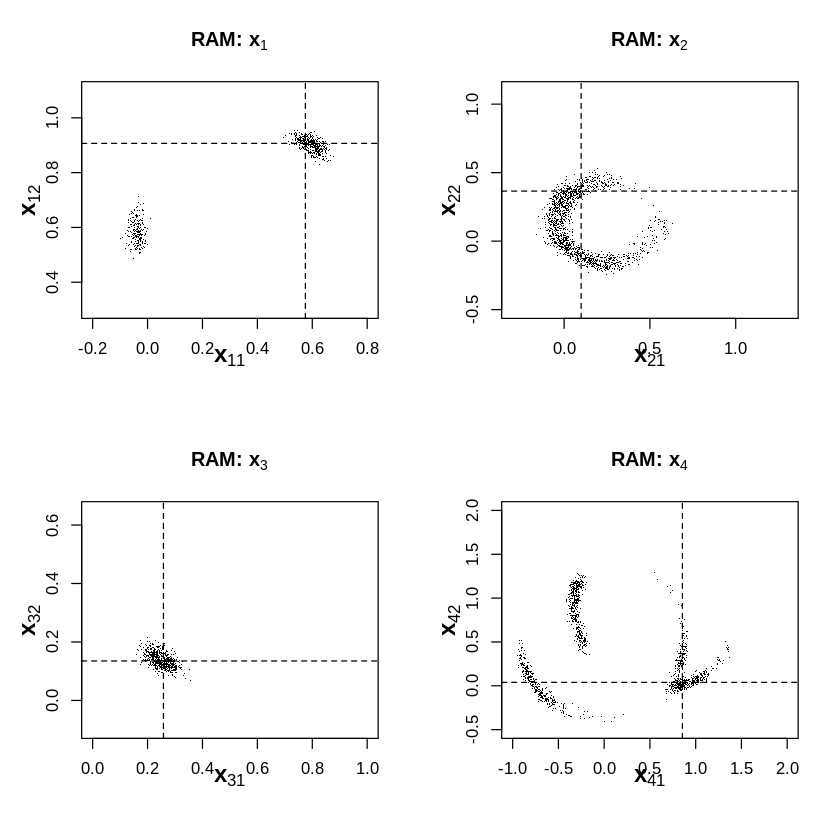

In [12]:
##graph



par(mfrow=c(2,2))

plot(res.ram$x[, c(1, 2)], pch = 46, xlim = c(-0.2, 0.8), ylim = c(0.3, 1.1),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[1]))))
mtext(side = 1, text = expression(bold(x[11])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[12])), line = 1.9, cex = 1.2)
abline(v = 0.5748, lty = 2, lwd = 1)
abline(h = 0.9069, lty = 2, lwd = 1)

plot(res.ram$x[, c(3, 4)], pch = 46, xlim = c(-0.3, 1.3), ylim = c(-0.5, 1.1),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[2]))))
mtext(side = 1, text = expression(bold(x[21])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[22])), line = 1.9, cex = 1.2)
abline(v = 0.0991, lty = 2, lwd = 1)
abline(h = 0.3651, lty = 2, lwd = 1)

plot(res.ram$x[, c(5, 6)], pch = 46, xlim = c(0, 1), ylim = c(-0.1, 0.65),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[3]))))
mtext(side = 1, text = expression(bold(x[31])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[32])), line = 1.9, cex = 1.2)
abline(v = 0.2578, lty = 2, lwd = 1)
abline(h = 0.1350, lty = 2, lwd = 1)

plot(res.ram$x[, c(7, 8)], pch = 46, xlim = c(-1, 2), ylim = c(-0.5, 2),
     xlab = "", ylab = "", main = "")
title(expression(bold(paste("RAM: ", x[4]))))
mtext(side = 1, text = expression(bold(x[41])), line = 1.6, cex = 1.2)
mtext(side = 2, text = expression(bold(x[42])), line = 1.9, cex = 1.2)
abline(v = 0.8546, lty = 2, lwd = 1)
abline(h = 0.0392, lty = 2, lwd = 1)

In [0]:
hist(res.ram$x[, 1], 50, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 11), xlim = c(-0.2, 0.75))
title(expression(bold(paste("RAM: ", x[11]))))
mtext(side = 1, text = expression(bold(x[11])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
index <- which(!is.na(res))
lines(density(res.ram.den$x[, 1]), lwd = 1.5)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.5748, lty = 2, lwd = 2)



hist(res.ram$x[, 3], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 3), xlim = c(-0.15, 1.3))
title(expression(bold(paste("RAM: ", x[21]))))
mtext(side = 1, text = expression(bold(x[21])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.8, cex = 1.2, las = 0)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
lines(density(res.ram.den$x[, 3]), lwd = 1.5)
abline(v = 0.1, lty = 2, lwd = 2)


hist(res.ram$x[, 5], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 15), xlim = c(0.15, 0.85))
mtext(side = 1, text = expression(bold(x[31])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
index <- which(!is.na(res))
title(expression(bold(paste("RAM: ", x[31]))))
lines(density(res.ram.den$x[, 5]), lwd = 1.5)
legend("top", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.2578, lty = 2, lwd = 2)


hist(res.ram$x[, 7], 30, prob = TRUE, main = "", xlab = "", ylab = "",
     ylim = c(0, 2.3), xlim = c(-1.1, 1.8))
mtext(side = 1, text = expression(bold(x[41])), line = 1.6, cex = 1.2)
mtext(side = 2, text = "Density", line = 1.7, cex = 1.2, las = 0)
title(expression(bold(paste("RAM: ", x[41]))))
lines(density(res.ram.den$x[, 7]), lwd = 1.5)
legend("topleft", c(expression(bold("Marginal dist.")), 
                    expression(bold("True location"))), lwd = 3, 
       bty = "n", seg.len = 0.9, cex = 0.9, lty = c(1, 3))
abline(v = 0.85, lty = 2, lwd = 2)